## Задачи:
 * исследование двухпараметрической модели 
 * оптимизация ее относительно двух противоречащих друг другу критериев
 
## Замечания:

* Параметры модели влияют на массу детали и ее прочность, являющиеся исследуемыми критериями

* Массу детали можно рассчитать используя эмпирические формулы, для расчета прочности потребуется конечноэлементный расчет

* Параметры не являются независимыми (значение одного параметра, как правило, ограничивает область изменения второго), следовательно область допустимых значений (ОДЗ) параметров не является прямоугольной 

## Этапы решения:

1. Построение области ОДЗ и визуализация ее на графике

2. Генерация большого количества пар параметров из ОДЗ, равномерно покрывающих эту область, и расчет для каждой пары значений обоих критериев

3. Применение метода многокритериальной оптимизации, сводящих ее к двумерной однокритериальной оптимизации супер-критерия, являющегося функцией двух исходных критериев; получение эффективных по Парето решений

#### Параметры задачи: 
радиус R, толщина W
#### Критерий прочности: 
$$
\sigma_{экв} = \frac{\sqrt{2}}{2} \sqrt{(\sigma_1 - \sigma_2)^2 + \sigma_2^2 + \sigma_1^2}
$$
#### Метод многокритериальной оптимизации: 
Метод идеальной точки с евклидовым расстоянием
#### Граничные условия:
Зона *A* - полное закрепление

Зона *B* - распределенное усилие перпендикулярное границе
#### Минимальный размер элемента:
10 см
#### Описание детали:
Деталь - профиль сложной формы

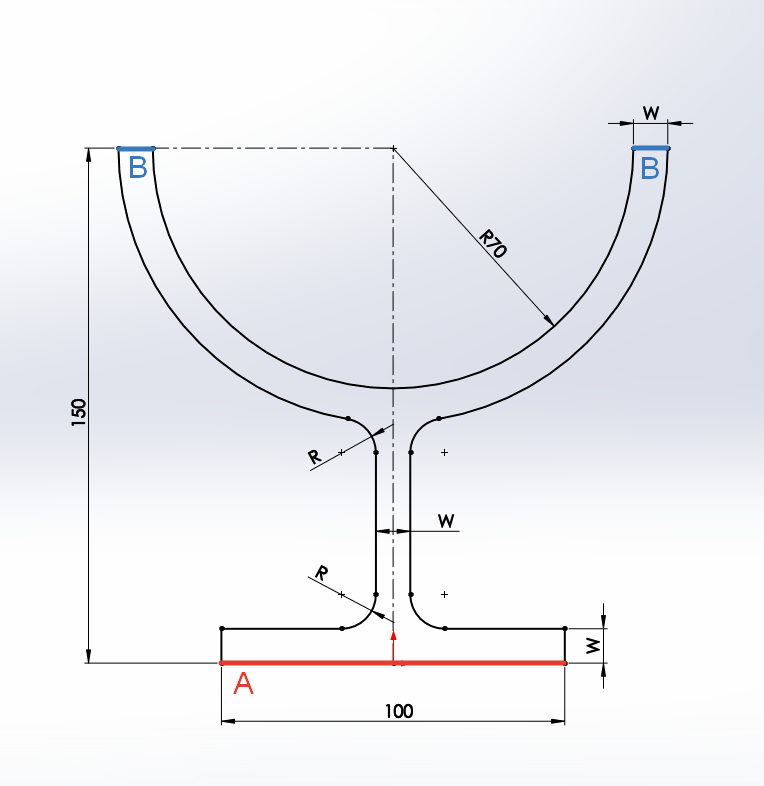

## Параметры стали, из которой изготовлена деталь

Модуль упругости (Юнга), $E$, ГПа | Коэффициент Пуассона, $\mu$ | Плотность стали, $\rho$, кг/м^3
------------ | ------------- | -------------
220 | 0.31 | 7000

In [42]:
import numpy as np
import scipy
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.optimize import bisect

In [43]:
def gen_finite_elements(R: float = 15, # радиус
                        W: float = 15, # толщина
                        nb: int = 50,   # количество узлов на границе основания
                        nm: float = 60,  # количество внутренних узлов
                        delta: float = 2, # отступ от границы
                        debug: bool = True # режим отладки
                       ):
    '''
    Генерирует узлы и треугольные конечные элементы для детали определенной формы.
    
    Parameters
    ----------
    
    R : float
        радиус кривизны (default: 15)
        
    W: float 
        толщина (default: 15)
    '''
    
    T = np.sqrt((70 + W + R)**2 - (W / 2 + R)**2)
    K = (70 + W) * (W / 2 + R) / (70 + W + R)
    L = (70 + W) * T / (70 + W + R)
    a = np.degrees(np.arcsin((W / 2 + R) / (70 + W + R)))
    
    n1 = nb
    G1x = np.linspace(50, -50, n1, endpoint = True)
    G1y = np.zeros_like(G1x)
    
    n2 = int(nb * W / 100)
    G2y = np.linspace(0, W, n2, endpoint = False) \
                                                            [1:]
    G2x = np.zeros_like(G2y) - 50
    
    n3 = int(nb * (50 - (W / 2 + R)) / 100)
    G3x = np.linspace(-50, -(W / 2 + R), n3, endpoint = False)
    G3y = np.zeros_like(G3x) + W
    
    n4 = int(nb * (360 - 270) / 360 * 2 * np.pi * R / 100)
    alpha = np.radians(np.linspace(270, 360, n4, endpoint = False))
    G4x = -(W / 2 + R) + R * np.cos(alpha)
    G4y = (W + R) + R * np.sin(alpha)
    
    n5 = int(nb * ((150 - T) - (W + R)) / 100)   
    G5y = np.linspace(W + R, 150 - T, n5, endpoint = False)
    G5x = np.zeros_like(G5y) - W / 2
    
    n6 = int(nb * (90 - a) / 360 * 2 * np.pi * R / 100) 
    alpha = np.radians(np.linspace(0, 90 - a, n6, endpoint = False))
    G6x = -(W / 2 + R) + R * np.cos(alpha)
    G6y = (150 - T) + R * np.sin(alpha)
    
    n7 = int(nb * (270 - a - 180) / 360 * 2 * np.pi * (70 + W) / 100) 
    alpha = np.radians(np.linspace(270 - a, 180, n7, endpoint = False))
    G7x = (70 + W) * np.cos(alpha)
    G7y = 150 + (70 + W) * np.sin(alpha)
    
    n8 = int(nb * W / 100)
    G8x = np.linspace(-(70 + W), -70, n8, endpoint = False)
    G8y = np.zeros_like(G8x) + 150
    
    n9 = int(nb * (360 - 180) / 360 * 2 * np.pi * 70 / 100)  
    alpha = np.radians(np.linspace(180, 360, n9, endpoint = False))
    G9x = 70 * np.cos(alpha)
    G9y = 150 + 70 * np.sin(alpha)
    
    n10 = int(nb * W / 100)
    G10x = np.linspace(70, 70 + W, n10, endpoint = False)
    G10y = np.zeros_like(G10x) + 150
    
    n11 = int(nb * (360 - (270 + a)) / 360 * 2 * np.pi * (70 + W) / 100) 
    alpha = np.radians(np.linspace(360, 270 + a, n11, endpoint = False))
    G11x = (70 + W) * np.cos(alpha)
    G11y = 150 + (70 + W) * np.sin(alpha)
    
    n12 = int(nb * (180 - (90 + a)) / 360 * 2 * np.pi * R / 100) 
    alpha = np.radians(np.linspace(90 + a, 180, n12, endpoint = False))
    G12x = (W / 2 + R) + R * np.cos(alpha)
    G12y = (150 - T) + R * np.sin(alpha)
    
    n13 = int(nb * ((150 - T) - (W + R)) / 100)
    G13y = np.linspace(150 - T, W + R, n13, endpoint = False)
    G13x = np.zeros_like(G13y) + W / 2
    
    n14 = int(nb * (270 - 180) / 360 * 2 * np.pi * R / 100) 
    alpha = np.radians(np.linspace(180, 270, n14, endpoint = False))
    G14x = (W / 2 + R) + R * np.cos(alpha)
    G14y = (W + R) + R * np.sin(alpha)
    
    n15 = int(nb * (50 - (W / 2 + R)) / 100)
    G15x = np.linspace(W / 2 + R, 50, n15, endpoint = False)
    G15y = np.zeros_like(G15x) + W
    
    n16 = int(nb * W / 100)
    G16y = np.linspace(W, 0, n16, endpoint = False)
    G16x = np.zeros_like(G16y) + 50
    
    GNodes = np.column_stack((
        np.row_stack((G1x, G1y)),
        np.row_stack((G2x, G2y)),
        np.row_stack((G3x, G3y)),
        np.row_stack((G4x, G4y)),
        np.row_stack((G5x, G5y)),
        np.row_stack((G6x, G6y)),
        np.row_stack((G7x, G7y)),
        np.row_stack((G8x, G8y)),
        np.row_stack((G9x, G9y)),
        np.row_stack((G10x, G10y)),
        np.row_stack((G11x, G11y)),
        np.row_stack((G12x, G12y)),
        np.row_stack((G13x, G13y)),
        np.row_stack((G14x, G14y)),
        np.row_stack((G15x, G15y)),
        np.row_stack((G16x, G16y)),
    )).T
    
    A1, A2 = 0, n1
    
    B1 = n1 + n2 + n3 + n4 + n5 + n6 + n7 - 1
    B2 = B1 + n8 + 1
    
    B3 = B2 + n9 - 1
    B4 = B3 + n10 + 1
    
    x,y = np.mgrid[-(70 + W) + delta : (70 + W) - delta : nm * 1j, delta : 150 - delta : nm*1j]
    INodes = np.column_stack((x.ravel(), y.ravel()))

    p = Path(GNodes, closed = True)
    mask = p.contains_points(INodes, radius = delta)
    
    INodes = INodes[mask]
    
    if debug:
        plt.figure(figsize = (12,12))
        plt.plot(*GNodes.T, '.k')
        plt.plot(*GNodes[A1 : A2].T, '.r')
        plt.plot(*GNodes[B1 : B2].T, '.b')
        plt.plot(*GNodes[B3 : B4].T, '.b')
        plt.plot(*INodes.T, '.c')
        plt.axis('equal')
        plt.show()

    Nodes = np.vstack((GNodes, INodes))
    tri = Delaunay(Nodes)
    Elems = tri.simplices.copy()
    
    Coords = Nodes[Elems]
    centers = Coords.mean(axis = 1)
    emask = p.contains_points(centers)
    Elems = Elems[emask]

    return Nodes, Elems, A1, A2, B1, B2, B3, B4

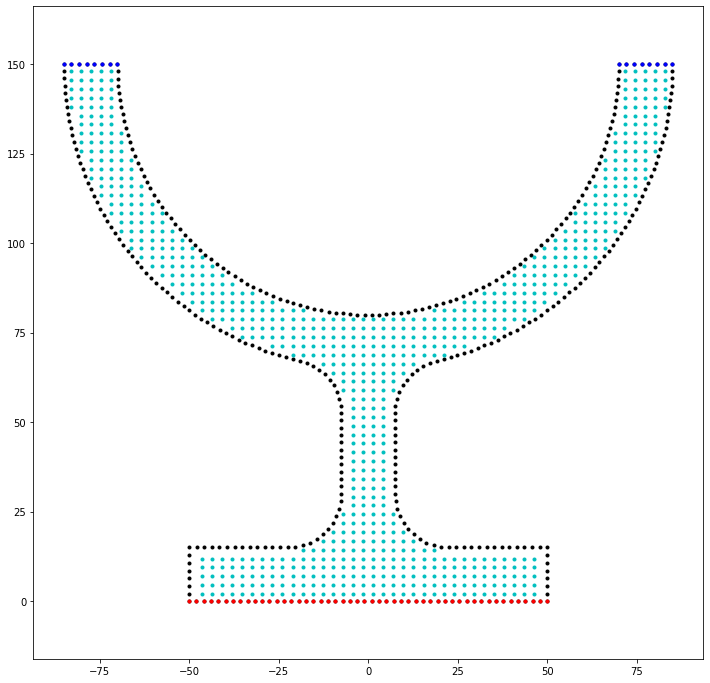

In [44]:
Nodes, Elems, A1, A2, B1, B2, B3, B4 = gen_finite_elements()

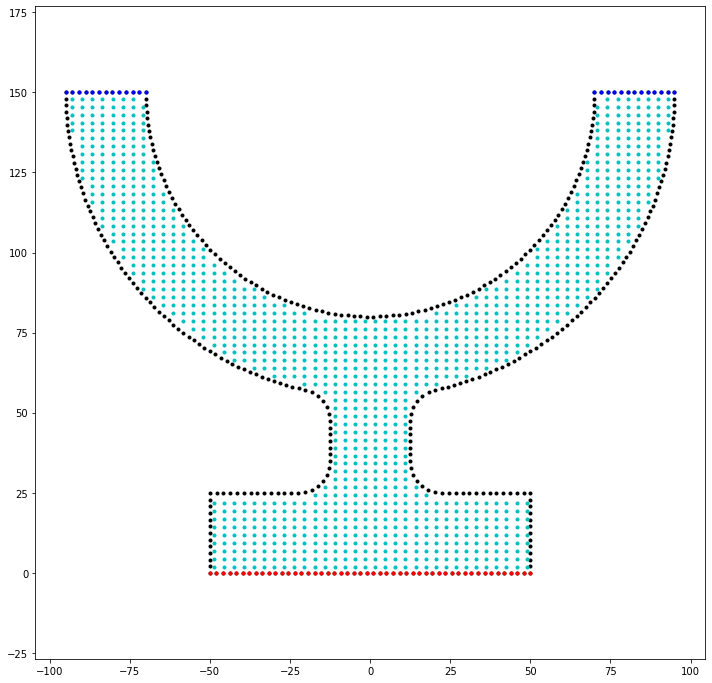

In [45]:
_ = gen_finite_elements(R = 10, W = 25)

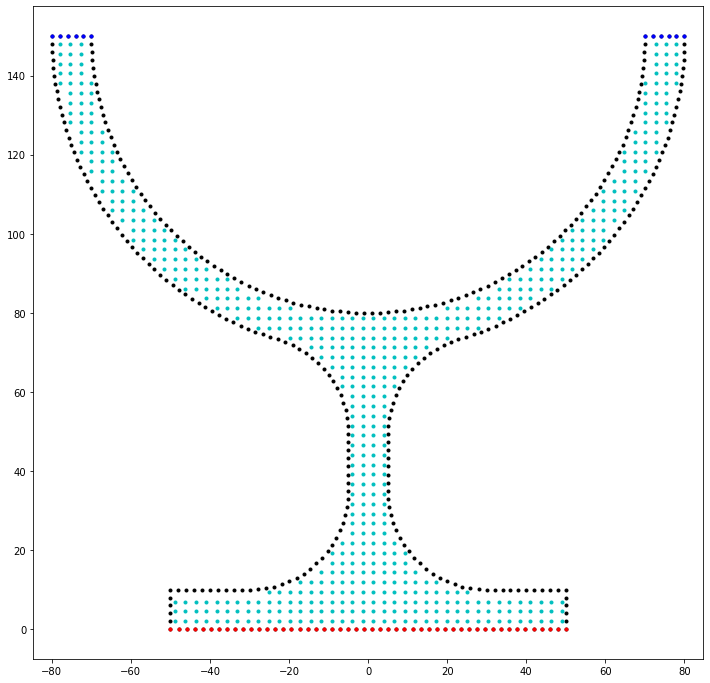

In [46]:
_ = gen_finite_elements(R = 25, W = 10)

## Построение ОДЗ и равномерное заполнение её узлами

In [47]:
min_element_size = 10

In [48]:
restrictions_1 = np.vectorize(lambda r, w: 50 - w / r - r)
restrictions_2 = np.vectorize(lambda r, w: 150 - np.sqrt((70 + w + r)**2 - (w / 2 + r)**2) - (w + r))

Text(0, 0.5, 'W')

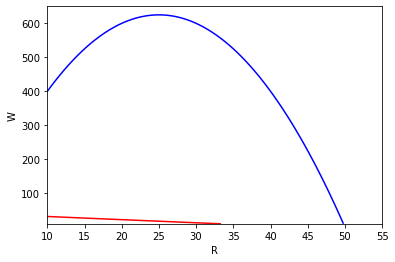

In [49]:
r_range = np.linspace(min_element_size, 55, 100)
w_range = np.linspace(min_element_size, 650, 100)

Rmesh, Wmesh = np.meshgrid(r_range, w_range)

R1 = restrictions_1(Rmesh, Wmesh)
plt.contour(Rmesh, Wmesh, R1, [0], colors = 'b')

R2 = restrictions_2(Rmesh, Wmesh)
plt.contour(Rmesh, Wmesh, R2, [0], colors = 'r')

plt.xlabel('R')
plt.ylabel('W')

Text(0, 0.5, 'W')

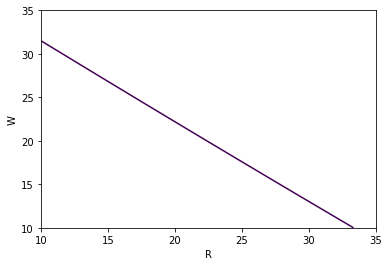

In [50]:
r_range = np.linspace(min_element_size, 35, 100)
w_range = np.linspace(min_element_size, 35, 100)

Rmesh, Wmesh = np.meshgrid(r_range, w_range)

R2 = restrictions_2(Rmesh, Wmesh)
plt.contour(Rmesh, Wmesh, R2, [0])

plt.xlabel('R')
plt.ylabel('W')

Text(0, 0.5, 'W')

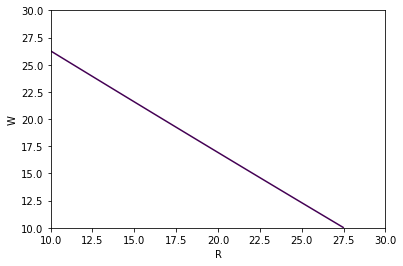

In [51]:
r_range = np.linspace(min_element_size, 30, 100)
w_range = np.linspace(min_element_size, 30, 100)

Rmesh, Wmesh = np.meshgrid(r_range, w_range)

R2 = restrictions_2(Rmesh, Wmesh)
c = plt.contour(Rmesh, Wmesh, R2, [min_element_size])

plt.xlabel('R')
plt.ylabel('W')

In [52]:
restriction_border = c.collections[0].get_paths()[0].vertices
restriction_border[:3]

array([[27.51761914, 10.        ],
       [27.37373737, 10.13181232],
       [27.29713438, 10.2020202 ]])

In [53]:
points_num = 500
bottom_border = np.vstack((np.linspace(10, restriction_border[0][0], points_num, endpoint = False), [10] * points_num)).T
left_border = np.vstack(([10] * points_num, np.linspace(restriction_border[-1][-1], 10, points_num, endpoint = False))).T
bottom_border[:3], left_border[:3]

(array([[10.        , 10.        ],
        [10.03503524, 10.        ],
        [10.07007048, 10.        ]]),
 array([[10.        , 26.2746088 ],
        [10.        , 26.24205958],
        [10.        , 26.20951037]]))

In [54]:
BNodes = np.column_stack((
        bottom_border.T,
        restriction_border.T,
        left_border.T
    )).T
BNodes

array([[10.        , 10.        ],
       [10.03503524, 10.        ],
       [10.07007048, 10.        ],
       ...,
       [10.        , 10.09764765],
       [10.        , 10.06509844],
       [10.        , 10.03254922]])

Text(0, 0.5, 'W')

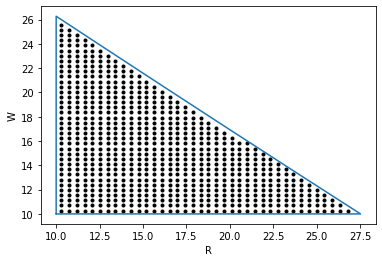

In [55]:
delta = 0.3

left_points_num = 40
bottom_points_num = int(left_points_num * restriction_border[0][0] / restriction_border[-1][-1])

x, y = np.mgrid[10 - delta / 2: restriction_border[0][0] + delta / 2 : bottom_points_num * 1j, \
                10 - delta / 2 : restriction_border[-1][-1] + delta / 2 : left_points_num * 1j]

ScopeNodes = np.column_stack((x.ravel(), y.ravel()))

p = Path(BNodes, closed = True)
mask = p.contains_points(ScopeNodes, radius = -delta)

ScopeNodes = ScopeNodes[mask]

plt.plot(*ScopeNodes.T, '.k')
plt.plot(*BNodes.T)

plt.xlabel('R')
plt.ylabel('W')

In [56]:
ScopeNodes.shape[0]

717

In [57]:
tri = Delaunay(ScopeNodes)
ScopeElems = tri.simplices.copy()
ScopeCoords = ScopeNodes[ScopeElems]
centers = ScopeCoords.mean(axis = 1)
emask = p.contains_points(centers)
ScopeElems = ScopeElems[emask]

## Построение контурных карт величины массы детали и величины критерия прочности на плоскости параметров (R, W)

In [91]:
# Плотность стали
density = 7000 # кг / м^3
density = 7000 / 100**3 # кг / см^3

# Толщина детали
thickness = 1

In [59]:
def m(r, w):
    T = np.sqrt((70 + w + r)**2 - (w / 2 + r)**2)
    a = np.degrees(np.arcsin((w / 2 + r) / (70 + w + r)))
    
    S = 100 * w \
        + r * (2 * r + w) - np.pi * r**2 / 2 \
        + (150 - np.sqrt((70 + w + r)**2 - (w / 2 + r)**2) - (w + r)) * w + \
        ((w / 2 + r) * T - a / 360 * np.pi * 70**2 - (90 - a) / 360 * np.pi * r**2) * 2 + \
        ((90 - a) / 360 * np.pi * (70 + w)**2 - (90 - a) / 360 * np.pi * 70**2) * 2 
    
    return density * (S * thickness)

In [60]:
ScopeNodes.max(axis = 0)

array([26.77673818, 25.57462886])

In [61]:
Mass = np.zeros(ScopeNodes.shape[0])

for i, node in enumerate(ScopeNodes):
    r, w = node[0], node[1]
    Mass[i] = m(r, w)

Text(0, 0.5, 'W')

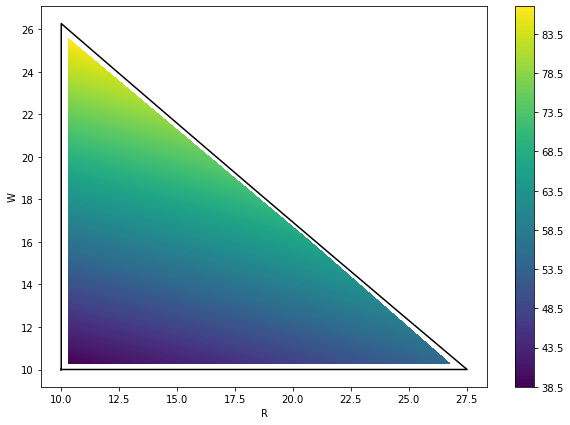

In [62]:
plt.figure(figsize=(10,7))
plt.plot(*BNodes.T,'k')
plt.plot(*BNodes[[-1, 0]].T,'k')
handle = plt.tricontourf(*ScopeNodes.T, ScopeElems, Mass, levels = 100)
plt.colorbar(handle)

plt.xlabel('R')
plt.ylabel('W')

In [63]:
def gen_stiffness_matrix(Nodes, Elems, E, mu, t):
    
    # считаем матрицу жесткости
    
    Coords = Nodes[Elems]
    b = Coords[:,[1, 2, 0],1] - Coords[:,[2, 0, 1],1]
    c = Coords[:,[2, 0, 1],0] - Coords[:,[1, 2, 0],0]
    v = Coords[:, [1, 2]] - Coords[:, [0, 0]]
    A = 0.5 * np.cross(v[:,0], v[:,1], axis=1) # площадь
    z = np.zeros(Coords.shape[0])
    B0 = np.column_stack((b[:,0], z, b[:,1], z, b[:,2], z))
    B1 = np.column_stack((z, c[:,0], z, c[:,1], z, c[:,2]))
    B2 = np.column_stack((c[:,0], b[:,0], c[:,1], b[:,1], c[:,2], b[:,2]))
    B = np.stack((B0, B1, B2), axis=2).transpose((0, 2, 1)) / (2*A.reshape(-1,1,1))
    
    D = E / (1 - mu**2) * np.array([[1, mu, 0],
                                    [mu, 1, 0],
                                    [0,  0, (1 - mu)/2]])
    Ve = A * t # объём элемента (Прямая треугольная призма)
    Ke = (B.transpose((0, 2, 1)) @ D @ B) * Ve[:,None,None]  # Ke = B.T @ D @ B @ Ve
    EFT = np.repeat(Elems*2, 2, axis=1)
    EFT[:, [1, 3, 5]] += 1
    
    N, M = Nodes.shape[0], Elems.shape[0
                                      ]
    K = np.zeros((2*N, 2*N))
    for e in range(M):
        p = EFT[e, None].T
        q = EFT[e]
        K[p, q] += Ke[e]
        
    return K, B, EFT, A, D

In [64]:
def freedom(nodes_idx, prj='x'):
    arr = np.array(nodes_idx)
    if prj == 'x':
        return arr * 2
    elif prj == 'y':
        return arr * 2 + 1
    elif prj == 'xy':
        return np.column_stack((arr * 2, arr * 2 + 1))
    
    raise ValueError(f'Need prj "x", "y" or "xy", got {prj}')

In [65]:
def zero_displacement(K, F, dof):
    
    # фиксируем заданные степени свободы узлов
    
    K[dof] = 0
    K[:,dof] = 0
    K[dof,dof] = 1
    F[dof] = 0
    return K, F

In [66]:
def surface_stress(F, Nodes, nodes_idx, t, p):
    
    # задаем распределенные узловые усилия
    
    n1, n2 = Nodes[nodes_idx[:2]]
    l12 = np.linalg.norm(n2 - n1)
    S12 = l12 * t
    dof = freedom(nodes_idx, 'xy')
    f = np.zeros((nodes_idx.shape[0], 2))
    f += 0.5 * S12 * p
    f[1:-1] *= 2
    F[dof] = f
    return F

In [67]:
def node_stress_eigvals(Elems, EFT, U, B, A, D):
    Eps = B @ U[EFT, None] # тензор деформаций
    Sig = D @ Eps # тензор напряжений
    
    N = U.shape[0] // 2

    SigN = np.zeros((N, 3)) # тензоры напряжений в узлах
    for n in range(N):
        mask = np.any(Elems == n, axis=1)
        Ae = A[mask]
        SigN[n] = Ae @ Sig[mask, : ,0] / np.sum(Ae)
        
    sq = ((SigN[:,0] - SigN[:,1])**2+4*SigN[:,2]**2)**0.5
    su = SigN[:,0] + SigN[:,1]
    SN = 0.5*np.column_stack((su + sq, su - sq))
    return SN

(-93.5, 93.5, -7.5, 157.5)

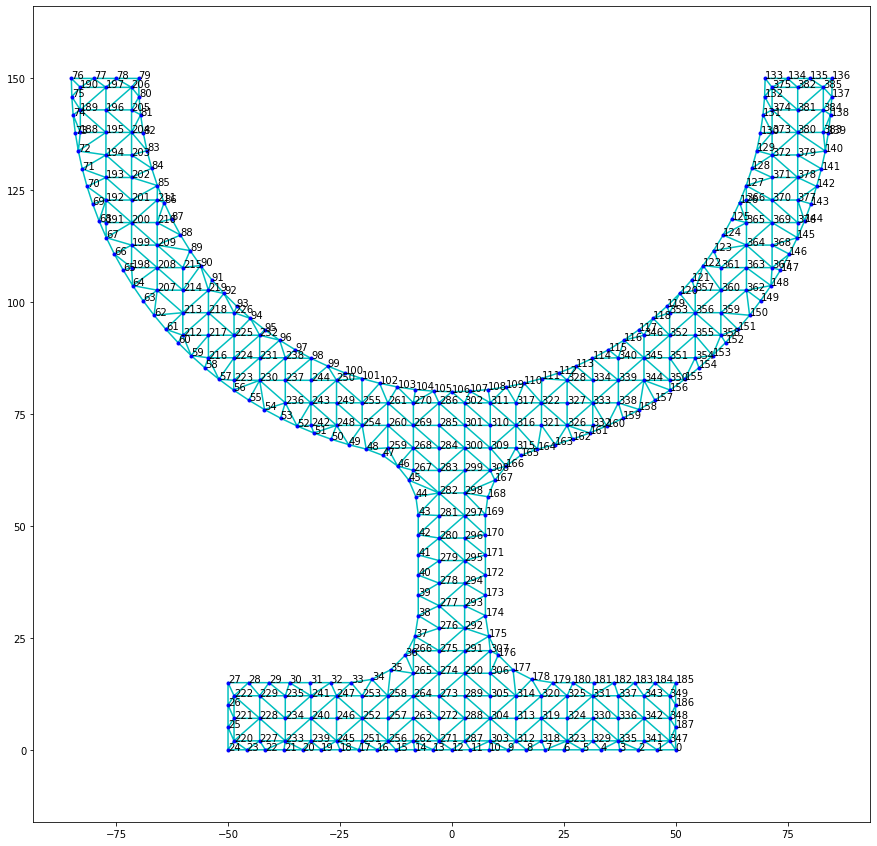

In [68]:
Nodes, Elems, A1, A2, B1, B2, B3, B4 = gen_finite_elements(nb = 25, nm = 30, debug = False)

plt.figure(figsize=(15, 15))
for i in range(Nodes.shape[0]):
    plt.text(*Nodes[i], f"{i}")
for i in range(Nodes.shape[0]):
    plt.plot(*Nodes[i], '.b')
plt.triplot(*Nodes.T, Elems, '-c')
plt.axis('equal')

In [69]:
# модуль упругости (Юнга):
E = 220e9   # Н / м^2 (= Па)
E = 220e5   # Н / см^2

# коэффициент Пуассона:
mu = 0.31   

In [70]:
alpha = np.radians(90)
p = 1000 * np.array([np.cos(alpha), np.sin(alpha)]) # в Ньютонах
p

array([6.123234e-14, 1.000000e+03])

(-93.5, 93.5, 0.0, 164.63173109822898)

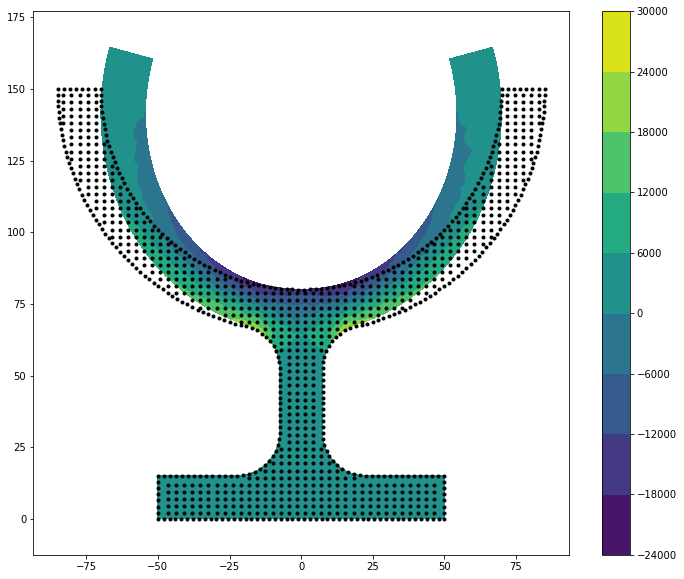

In [71]:
Nodes, Elems, A1, A2, B1, B2, B3, B4 = gen_finite_elements(debug = False)
K, B, EFT, A, D = gen_stiffness_matrix(Nodes, Elems, E, mu, t = thickness)
F = np.zeros(K.shape[0])
dof = freedom(np.arange(A1, A2), 'xy').ravel()
K, F = zero_displacement(K, F, dof)
F = surface_stress(F, Nodes, np.arange(B1, B2), t = thickness, p = p)
F = surface_stress(F, Nodes, np.arange(B3, B4), t = thickness, p = p)
U = np.linalg.solve(K, F)
SN = node_stress_eigvals(Elems, EFT, U, B, A, D)
SNmax = np.max(np.abs(SN), axis=1)
scale = 1 / np.max(np.abs(U))
scale = 40
rNodes = Nodes + scale * U.reshape(-1, 2)
SN = node_stress_eigvals(Elems, EFT, U, B, A, D)
SNmax = np.max(np.abs(SN), axis=1)
SNmax_sign = SN[np.abs(SN) == SNmax[:, None]]
plt.figure(figsize=(12, 10))
# plt.plot(*np.append(Nodes[:BN], [Nodes[0]], axis = 0).T, '-m')
handle = plt.tricontourf(*rNodes.T, Elems, SNmax_sign)
plt.colorbar(handle)
plt.plot(*Nodes.T, '.k')
plt.axis('equal')

(-69.89300614534267, 69.90184656434923, 0.0, 164.63173109822898)

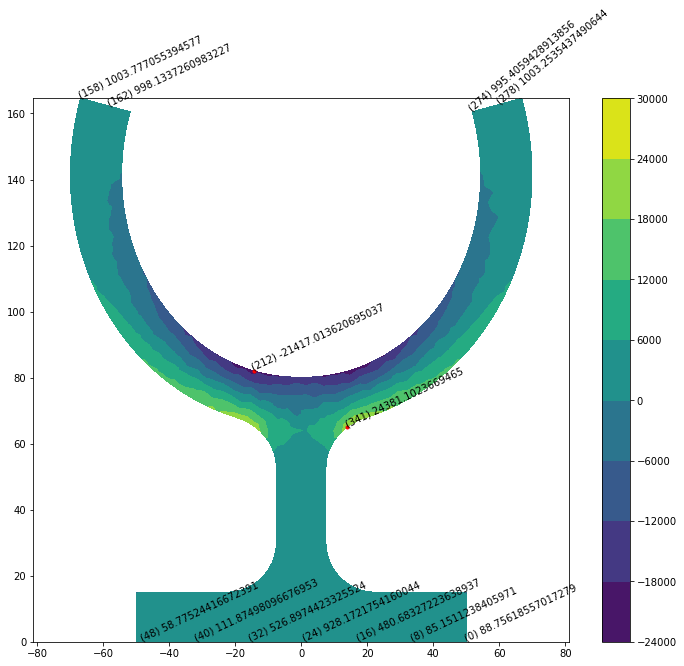

In [72]:
plt.figure(figsize=(12, 10))
handle = plt.tricontourf(*rNodes.T, Elems, SNmax_sign)
plt.colorbar(handle)
plt.plot(*rNodes[SNmax_sign.argmax()].T, '.r')
plt.text(*rNodes[SNmax_sign.argmax()].T, f"({SNmax_sign.argmax()}) {SNmax_sign.max()}", 
         rotation=25, rotation_mode='anchor')
plt.plot(*rNodes[SNmax_sign.argmin()].T, '.r')
plt.text(*rNodes[SNmax_sign.argmin()].T, f"({SNmax_sign.argmin()}) {SNmax_sign.min()}", 
         rotation=25, rotation_mode='anchor')
for n in range(A1, A2, 8):
    plt.text(*rNodes[n].T, f"({n}) {SNmax_sign[n]}", rotation=25, rotation_mode='anchor')
for n in range(B1, B2, 4):
    plt.text(*rNodes[n].T, f"({n}) {SNmax_sign[n]}", rotation=25, rotation_mode='anchor')
for n in range(B3, B4, 4):
    plt.text(*rNodes[n].T, f"({n}) {SNmax_sign[n]}", rotation=40, rotation_mode='anchor')
plt.axis('equal')

In [73]:
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
from IPython.display import clear_output
from tqdm import tqdm

In [74]:
def criterion(SN):
    SNmax = np.max(np.abs(SN), axis=1)
    SNmax_sign = SN[np.abs(SN) == SNmax[:, None]]
    abs_SNmax = list(np.abs(SNmax_sign))
    sigma_2, sigma_1 = np.sort(abs_SNmax)[-2:]
    sigma_2, sigma_1 = SNmax_sign[abs_SNmax.index(sigma_2)], SNmax_sign[abs_SNmax.index(sigma_1)]
    return np.sqrt(2) / 2 * np.sqrt((sigma_1 - sigma_2)**2 + sigma_2**2 + sigma_1**2)

def s1(r, w):
    Nodes, Elems, A1, A2, B1, B2, B3, B4 = gen_finite_elements(R = r, W = w, debug = False)
    K, B, EFT, A, D = gen_stiffness_matrix(Nodes, Elems, E, mu, t = thickness)
    F = np.zeros(K.shape[0])
    dof = freedom(np.arange(A1, A2), 'xy').ravel()
    K, F = zero_displacement(K, F, dof)
    F = surface_stress(F, Nodes, np.arange(B1, B2), t = thickness, p = p)
    F = surface_stress(F, Nodes, np.arange(B3, B4), t = thickness, p = p)
    U = spsolve(csr_matrix(K), F)
    SN = node_stress_eigvals(Elems, EFT, U, B, A, D)
    return criterion(SN)

In [75]:
Stress = np.zeros(ScopeNodes.shape[0])

for i, node in enumerate(tqdm(ScopeNodes)):
    Stress[i] = s1(*node)

100%|████████████████████████████████████████████████████████████████████████████████| 717/717 [02:58<00:00,  4.02it/s]


Text(0, 0.5, 'W')

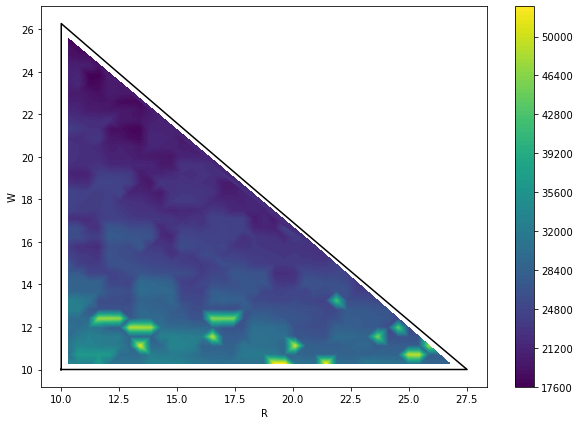

In [76]:
plt.figure(figsize=(10,7))
plt.plot(*BNodes.T,'k')
plt.plot(*BNodes[[-1, 0]].T,'k')
handle = plt.tricontourf(*ScopeNodes.T, ScopeElems, Stress, levels = 100)
plt.colorbar(handle)

plt.xlabel('R')
plt.ylabel('W')

## Построение облака точек на плоскости критериев (Stress, Mass)

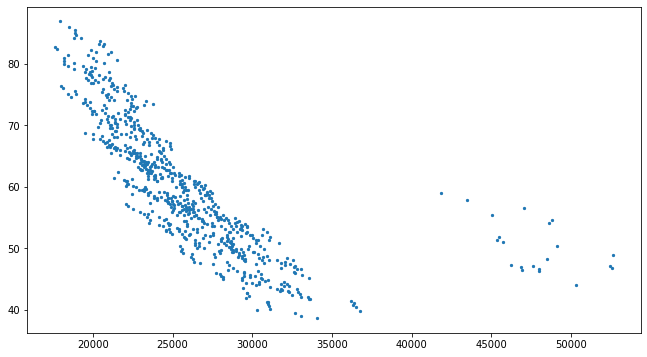

In [77]:
plt.figure(figsize = (11, 6))
plt.scatter(Stress, Mass, s = 5)

## Реализация дискретной многокритериальной оптимизации

In [78]:
import pandas as pd

In [79]:
def super_criterion(r_ideal, w_ideal, r, w, r_max, w_max):
    r_ideal /= r_max
    w_ideal /= w_max
    r /= r_max
    w /= w_max
#     print(r_ideal, w_ideal, r, w, r_max, w_max)
    return np.sqrt((w - w_ideal)**2 + (r - r_ideal)**2)

In [80]:
ScopeNodes.max(axis = 0)

array([26.77673818, 25.57462886])

In [81]:
table = []

ideal_1_s, ideal_1_m = Stress.min(), Mass.min() + 5
ideal_2_s, ideal_2_m = Stress.min() + 2000, Mass.min()

for i, node in enumerate(ScopeNodes):
    row = [*ScopeNodes[i]]
    row.append(Stress[i]),
    row.append(Mass[i]),
    sc = super_criterion(ideal_1_s, ideal_1_m, Stress[i], Mass[i], Stress.max(), Mass.max())
    row.append(sc)
    sc = super_criterion(ideal_2_s, ideal_2_m, Stress[i], Mass[i], Stress.max(), Mass.max())
    row.append(sc)
    table.append(row)
    
table = pd.DataFrame(table, columns = ['R', 'W', 'Напряжение', 'Масса', 
                                        f'Значение супер-критерия для идеальной т. ({ideal_1_s}, {ideal_1_m})',
                                        f'Значение супер-критерия для идеальной т. ({ideal_2_s}, {ideal_2_m})'])
table

,R,W,Напряжение,Масса,"Значение супер-критерия для идеальной т. (17612.045125783447, 43.63971428440928)","Значение супер-критерия для идеальной т. (19612.045125783447, 38.63971428440928)"
0,10.295440,10.27499,34040.697074,38.639714,0.317387,0.274129
1,10.295440,10.69998,30281.911832,39.978068,0.244375,0.203300
2,10.295440,11.12497,31000.726025,41.316534,0.255772,0.218555
3,10.295440,11.54996,29685.663746,42.655114,0.229666,0.196888
4,10.295440,11.97495,30262.766697,43.993807,0.240385,0.211526
...,...,...,...,...,...,...
712,25.885857,10.69998,27954.817476,55.066354,0.236444,0.246701
713,25.885857,11.12497,47049.421072,56.460080,0.578413,0.560173
714,26.331298,10.27499,28914.247213,54.165072,0.246539,0.251313
715,26.331298,10.69998,27747.022663,55.560224,0.236426,0.248610


In [82]:
r1, w1, st1, m1 = table.iloc[table.iloc[:, -2].idxmin()][:-2]
r2, w2, st2, m2 = table.iloc[table.iloc[:, -1].idxmin()][:-2]

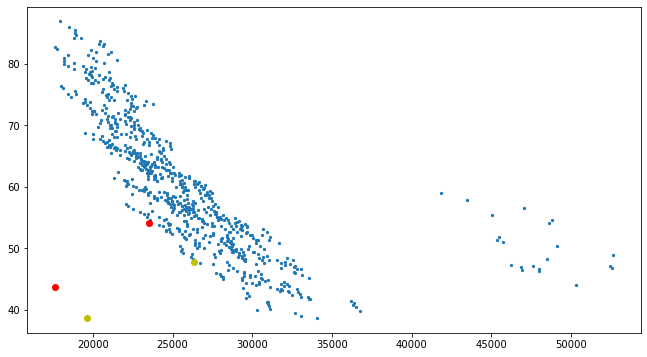

In [83]:
plt.figure(figsize = (11, 6))
plt.scatter(Stress, Mass, s = 5)
plt.plot(st1, m1, 'ro')
plt.plot(ideal_1_s, ideal_1_m, 'ro')
plt.plot(st2, m2, 'yo')
plt.plot(ideal_2_s, ideal_2_m, 'yo')

Text(0, 0.5, 'W')

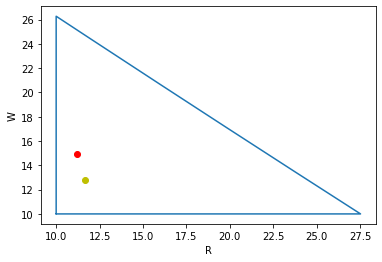

In [84]:
# plt.plot(*ScopeNodes.T, '.k')
plt.plot(*BNodes.T)

plt.plot(r1, w1, 'ro')
plt.plot(r2, w2, 'yo')

plt.xlabel('R')
plt.ylabel('W')

## Реализация непрерывной многокритериальной оптимизации

In [85]:
import scipy.optimize as sopt

In [86]:
wp1, rp1 = 10, BNodes.max(axis = 0)[1]
wp2, rp2 = BNodes.max(axis = 0)[0], 10

In [87]:
def G(R, W, lst = []):
    lst.append([R,W])
    if (R >= 10) and (W >= 10) and (W - wp1 - (R - rp1) / (rp2 - rp1) * (wp2 - wp1) <= 0):
        return super_criterion(ideal_1_s, ideal_1_m, s1(R, W), m(R, W), Stress.max(), Mass.max())
    else:
        return 1e15
    
lst = []
ret = sopt.minimize(lambda P, lst: G(P[0], P[1], lst), [15., 15], args = (lst,),
                    method='Nelder-Mead', 
                    options={'xatol': 1e-9, 'disp': True, 'maxiter':100000})
arr = np.array(lst)
p1 = lst[-1]

Optimization terminated successfully.
         Current function value: 0.176852
         Iterations: 84
         Function evaluations: 225


In [88]:
def G(R, W, lst = []):
    lst.append([R,W])
    if (R >= 10) and (W >= 10) and (W - wp1 - (R - rp1) / (rp2 - rp1) * (wp2 - wp1) <= 0):
        return super_criterion(ideal_2_s, ideal_2_m, s1(R, W), m(R, W), Stress.max(), Mass.max())
    else:
        return 1e15
    
lst = []
ret = sopt.minimize(lambda P, lst: G(P[0], P[1], lst), [15., 15], args = (lst,),
                    method='Nelder-Mead', 
                    options={'xatol': 1e-9, 'disp': True, 'maxiter':100000})
arr = np.array(lst)

p2 = arr[-1]

Optimization terminated successfully.
         Current function value: 0.184198
         Iterations: 89
         Function evaluations: 232


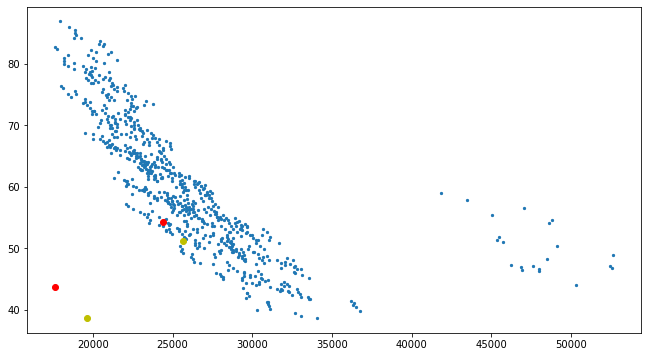

In [89]:
plt.figure(figsize = (11, 6))
plt.scatter(Stress, Mass, s = 5)

plt.plot(s1(*p1), m(*p1), 'ro')
plt.plot(ideal_1_s, ideal_1_m, 'ro')

plt.plot(s1(*p2), m(*p2), 'yo')
plt.plot(ideal_2_s, ideal_2_m, 'yo')

Text(0, 0.5, 'W')

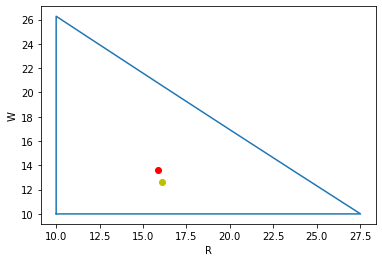

In [90]:
# plt.plot(*ScopeNodes.T, '.k')
plt.plot(*BNodes.T)

plt.plot(*p1, 'ro')
plt.plot(*p2, 'yo')

plt.xlabel('R')
plt.ylabel('W')